# Part3 Modeling

In this section, we build regression models to predict housing prices using cleaned and engineered features. We compare multiple models, tune hyperparameters, and evaluate their performance using RMSE and R².

本部分将基于清洗后的特征构建房价预测模型。我们将比较多种回归模型，使用网格搜索调参，并通过 RMSE 和 R² 等指标评估模型表现。

In [6]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("C:\\Users\\lyp\\Desktop\\HousePrice\\data\\house_data_cleaned.csv")
df.head()


,price,rooms,halls,area,orientation,decoration,floor_level,total_floor,building_type,community,subdistrict
0,3780000.0,3.0,2.0,118.16,"南,北,",简装,高,28.0,板楼,保利华都,虎泉杨家湾
1,2150000.0,4.0,2.0,133.51,"南,",毛坯,低,32.0,塔楼,东原启城一期,白沙洲
2,1680000.0,3.0,2.0,93.09,"南,",精装,中,33.0,板楼,保利心语九期,珞狮南路
3,3550000.0,3.0,1.0,123.56,"南,北,",精装,中,34.0,板楼,保利华都,虎泉杨家湾
4,1180000.0,3.0,1.0,95.65,"东南,",精装,低,33.0,板楼,美好长江首玺,白沙洲


In [7]:
df.isna().sum()
df.dropna(inplace=True)

In [8]:
df.isna().sum()

price            0
rooms            0
halls            0
area             0
orientation      0
decoration       0
floor_level      0
total_floor      0
building_type    0
community        0
subdistrict      0
dtype: int64

## 1.Features Engineering 特征工程

In [9]:
# Feature list
numeric_features = ["area", "rooms", "halls", "total_floor"]
categorical_features = ["orientation","decoration","floor_level", "building_type", "subdistrict"]

X = df[numeric_features + categorical_features]
y = df["price"]

# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


## 2.Split Train/Test 划分测试集和训练集

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 3. Modeling 建模

### 3.1 Train Baseline Model: Linear Regression 基线模型：线性回归

In [11]:
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)


Linear Regression RMSE: 833241.8794353043
Linear Regression R2: 0.7871788028892809


### 3.2 Random Forest Model 随机森林模型

In [12]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10, 20],
}

grid_rf = GridSearchCV(rf_model, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_rf.fit(X_train, y_train)

y_pred_rf = grid_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)
print("Best parameters:", grid_rf.best_params_)


Random Forest RMSE: 662215.0213096404
Random Forest R2: 0.8655778746582539
Best parameters: {'model__max_depth': 20, 'model__n_estimators': 300}


### 3.3 XGBoost Model

In [13]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        eval_metric="rmse"
    ))
])

param_grid_xgb = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.05, 0.1, 0.2]
}

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring="neg_root_mean_squared_error")
grid_xgb.fit(X_train, y_train)

y_pred_xgb = grid_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R2:", r2_xgb)
print("Best parameters:", grid_xgb.best_params_)


XGBoost RMSE: 774014.0591819682
XGBoost R2: 0.8163586821731184
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 400}


## 4.Model Comparion 模型对比

In [14]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "R2": [r2_lr, r2_rf, r2_xgb]
})

results

,Model,RMSE,R2
0,Linear Regression,833241.879435,0.787179
1,Random Forest,662215.021310,0.865578
2,XGBoost,774014.059182,0.816359


## 5. Feature Evaluation

### 5.1 Random forest

In [ ]:
# ========== Step 0: Get all feature names ==========
# 从最佳随机森林模型中提取预处理器和模型
# get the preprocessor and model from the best random forest model
preprocessor = grid_rf.best_estimator_.named_steps["preprocessor"]
rf_model_only = grid_rf.best_estimator_.named_steps["model"]

# 数值特征名
# name of numeric features
numeric_feature_names = numeric_features

# OneHot 后的分类特征名
# name of categorical features after OneHot encoding
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# 合并成 all_feature_names
# combine into  all_feature_names
all_feature_names = list(numeric_feature_names) + list(cat_feature_names)

# ========== Step 1： Gain original importance ==========
fi = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf_model_only.feature_importances_
})

# ========== Step 2： Aggregate (restore OneHot to original features) ==========
from collections import defaultdict

aggregate_importance = defaultdict(float)

for feature, importance in zip(fi["feature"], fi["importance"]):
    original_name = feature.split("_")[0]
    aggregate_importance[original_name] += importance

# ========== Step 3： Convert to DataFrame ==========
agg_df = pd.DataFrame({
    "feature": list(aggregate_importance.keys()),
    "importance": list(aggregate_importance.values())
}).sort_values("importance", ascending=False)

agg_df


,feature,importance
0,area,0.737076
8,subdistrict,0.118672
3,total,0.066440
6,floor,0.026446
1,rooms,0.014887
4,orientation,0.012736
5,decoration,0.011420
2,halls,0.007800
7,building,0.004521


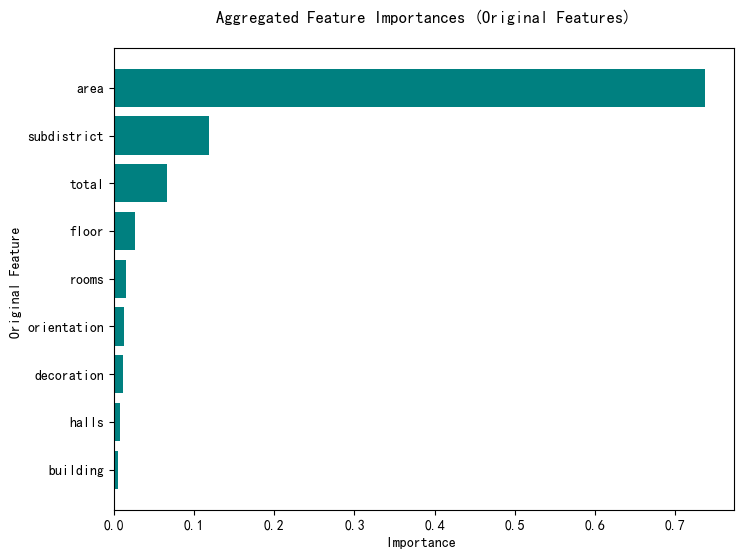

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.barh(agg_df["feature"], agg_df["importance"], color="teal")
plt.gca().invert_yaxis()
plt.title("Aggregated Feature Importances (Original Features)\n")
plt.xlabel("Importance ")
plt.ylabel("Original Feature ")
plt.show()



### 5.2 SHAP 

In [19]:
import sys
!{sys.executable} -m pip install shap


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


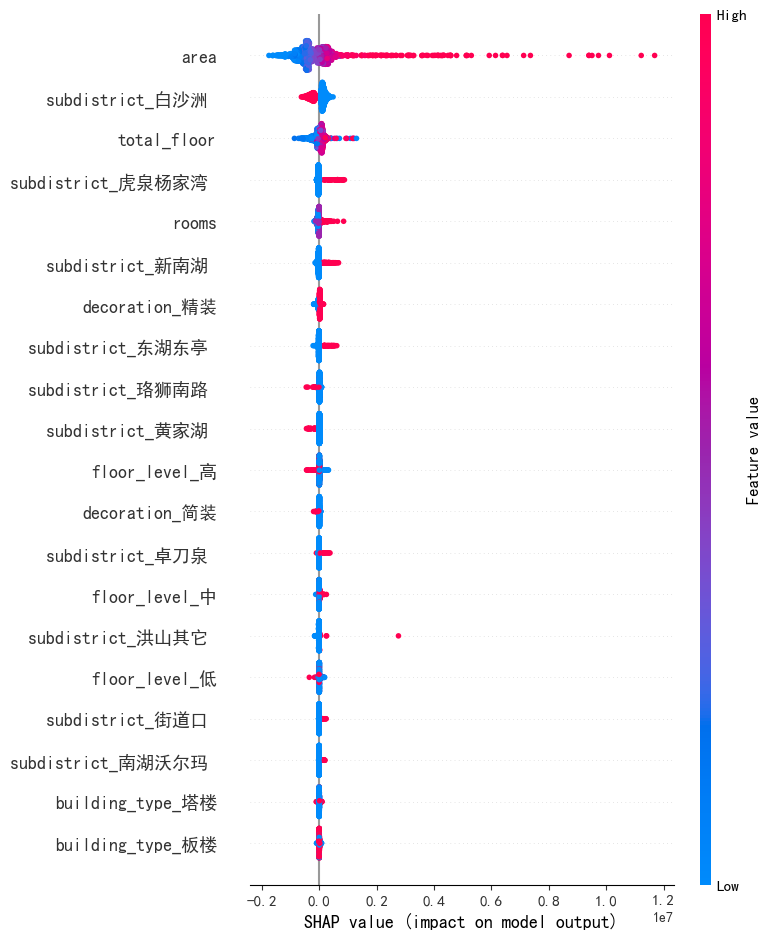

In [21]:
import shap

import numpy as np

best_rf = grid_rf.best_estimator_
preprocessor = best_rf.named_steps["preprocessor"]
rf_model = best_rf.named_steps["model"]

# 1. Transform X
X_train_transformed = preprocessor.transform(X_train)

# 2. Convert to dense float matrix for SHAP
if hasattr(X_train_transformed, "toarray"):
    X_train_dense = X_train_transformed.toarray().astype(float)
else:
    X_train_dense = X_train_transformed.astype(float)

# 3. SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_train_dense)

# 5. SHAP summary plot
shap.summary_plot(shap_values, X_train_dense, feature_names=all_feature_names)

## 6. Insights

Overall Logic: Spatial Value → Location Value → Livability Value → Cosmetic Value


Spatial value (area) sets the foundation of price.

Location value (subdistrict) shapes price differentiation.

Livability value (floor level & total floors) adjusts perceived quality.

Cosmetic value (decoration/layout) enhances appeal but is not decisive.

Price logic in Hongshan District can be summarized as:
“Area determines value, location differentiates value, livability refines value, decoration enhances perception.”

总体洞察结构：空间价值（面积） → 区域价值（片区） → 居住价值（楼层） → 辅助价值（装修/户型）


空间价值（面积）奠定房价基础。

区域价值（片区）决定价格差异化。

居住价值（楼层）调整品质与溢价。

辅助价值（装修/户型）提供加分但非决定性。

洪山区二手房的价值逻辑清晰：空间是底、区域是核、楼层是体验、装修是偏好。

The model results reveal that housing prices in Hongshan District are primarily shaped by a combination of intrinsic property characteristics and external neighborhood attributes. Among all features, area emerges as the dominating explanatory factor, as confirmed by both feature importance rankings and SHAP analysis. Larger homes consistently yield higher predicted prices, indicating that usable living space forms the fundamental layer of value perception in the local housing market. In other words, area establishes the baseline of how homes are priced, and buyers show a strong, consistent preference for greater living space.

Beyond physical size, location (subdistrict) plays a substantial and essential role in differentiating property values. The SHAP plot shows clear positive and negative impacts across different neighborhoods, reflecting variations in school district quality, accessibility, commercial density, and overall community development. This suggests that location acts as the “second layer” of value—amplifying or discounting the baseline provided by area. Homes of identical size can command significantly different prices depending solely on the neighborhood.

Floor-related characteristics introduce another meaningful layer of influence. High-floor units tend to increase predicted prices, whereas low-floor units suppress them, underscoring buyers’ sensitivity to lighting, noise, and overall living comfort. Meanwhile, the total number of floors in a building reflects structural quality and building age, which also shapes buyer perception and contributes to pricing differences.

In contrast, decoration, orientation, and room layout serve as tertiary factors. Although premium decoration and favorable orientations provide some price uplift, their impact is modest compared with area and location. These factors influence desirability but rarely override fundamental spatial or locational value.

Overall, the model reveals a layered logic of price formation in Hongshan District: “spatial value establishes the foundation, neighborhood value shapes differentiation, and livability value refines the final outcome.” The essential worth of a property is determined by its size; its market position is shaped by its location; and its liveability characteristics—such as floor level and building type—adjust the price within that range. Decoration and layout enhance desirability but do not fundamentally determine value. This structured insight not only aligns with model behavior but also reflects authentic market dynamics.

从数据结果来看，洪山区的二手房价格主要由房屋本身的物理属性与其所在区域共同决定。首先，面积无论在特征重要性还是 SHAP 分析中都表现为最核心的影响因素，是房价差异最直接、最具解释力的来源。面积越大，房价越高的趋势十分显著，反映出市场对居住空间的刚性需求；这意味着，在评估房产价值时，面积几乎构成定价的基础结构。

紧随其后的是片区（subdistrict）所体现的地段价值，这在 SHAP 图中表现为不同区域对价格预测产生明显的正负差异。地段的好坏不仅关乎学区、交通、商业与社区氛围，更体现了买家对“未来预期”的判断。因此，区域性差异成为压在面积之上的第二层价值来源，使得同样面积的房子因为所在片区不同而出现显著的价格差异。

楼层相关特征也呈现出有意义的影响方向。从 SHAP 可以看到，高楼层通常带来正向影响，而低楼层则产生负向推力，这说明居住体验（采光、噪音、湿度）在二手房选择中具有持续而可见的影响力。同时，总楼层数作为建筑年代、结构质量的 proxy，也在模型中发挥了一定作用。

相比之下，装修、朝向与户型（rooms/halls）则属于“次级影响因素”。虽然精装修确实能够增加一定溢价，户型更合理的房屋也更受欢迎，但这些因素的影响幅度远弱于面积和区域。这说明买家在做价值判断时，更看重房屋的基础价值，而装修等可变因素往往无法弥补区域与面积上的短板。

综合来看，洪山区的房价形成逻辑是“空间价值为底、区域价值为核、居住价值为辅”。房屋本身的使用价值决定了其基本定价，而片区价值进一步放大差异；楼层与建筑特性共同决定了居住体验的细微调整；装修与户型则成为锦上添花而非决定性的因素。这一结构化的价值逻辑不仅解释了模型的行为，也与真实房产市场的规律高度一致。